In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 4
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-5.657 -5.372 -4.374 -3.901 -3.901 -3.254 -1.716 -1.716]


In [5]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []
H_eigvecs_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals, eigvecs = jnp.linalg.eigh(H)
    H_eigvals_sweep.append(eigvals)
    H_eigvecs_sweep.append(eigvecs)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T
H_eigvecs_sweep = jnp.array(H_eigvecs_sweep)

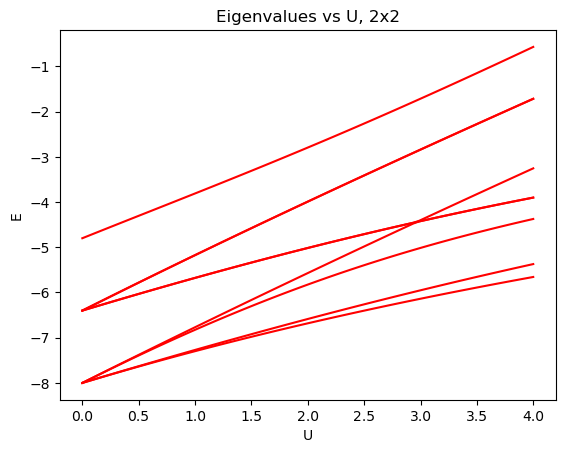

In [6]:
for band in range(9):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

## State fidelity vs U

In [7]:
Fidelity_sweep0 = [jnp.abs(jnp.real(H_eigvecs_sweep[-1, :, 0]@H_eigvecs_sweep[idx, :, 0])) for idx in range(len(U_sweep_ED))]
Fidelity_sweep1 = [jnp.abs(jnp.real(H_eigvecs_sweep[-1, :, 1]@H_eigvecs_sweep[idx, :, 1])) for idx in range(len(U_sweep_ED))]
Fidelity_sweep2 = [jnp.abs(jnp.real(H_eigvecs_sweep[-1, :, 2]@H_eigvecs_sweep[idx, :, 2])) for idx in range(len(U_sweep_ED))]

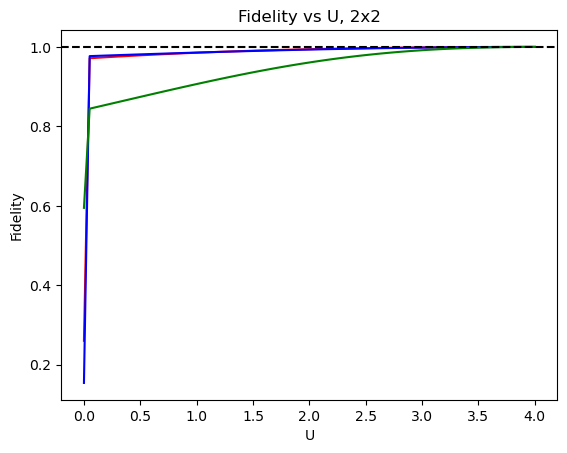

In [8]:
plt.plot(U_sweep_ED, Fidelity_sweep0, 'red')
plt.plot(U_sweep_ED, Fidelity_sweep1, 'blue')
plt.plot(U_sweep_ED, Fidelity_sweep2, 'green')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('U')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

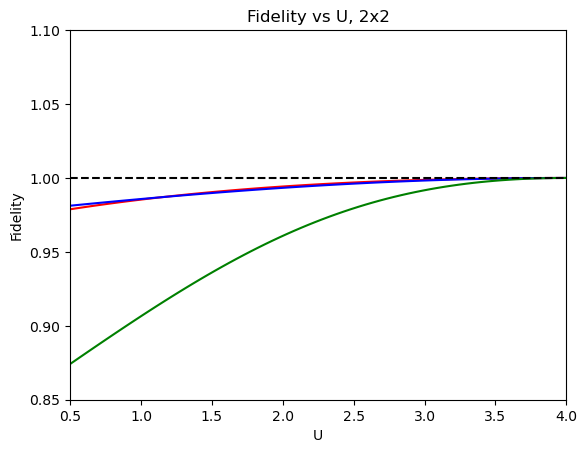

In [9]:
plt.plot(U_sweep_ED, Fidelity_sweep0, 'red')
plt.plot(U_sweep_ED, Fidelity_sweep1, 'blue')
plt.plot(U_sweep_ED, Fidelity_sweep2, 'green')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlim(0.5, 4)
plt.ylim(0.85, 1.1)
plt.xlabel('U')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [10]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [11]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-8.  -8.  -8.  -8.  -6.4 -6.4 -6.4 -6.4]


In [12]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:2])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [4, 4, 1, 4, 10, 4, 1, 4, 4]
Number of degerate Eigenvalues:
 [4, 4]
Eigenvalues of first Hi: 
 [0.75 0.75 1.25 1.25]


In [13]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [14]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [15]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [16]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

## Eigenbranches (error $ = 10^{-8}$)

In [17]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [18]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 150
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [19]:
Eigenbranches = []
Eigenbranches_states = []

for En in Energy:
    Schur = Schur_complement_qsp(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa)
    sub_eigvals, sub_eigvecs = jnp.linalg.eigh(Schur)
    Eigenbranches.append(sub_eigvals)
    Eigenbranches_states.append(sub_eigvecs)
Eigenbranches = jnp.array(Eigenbranches).T
Eigenbranches_states = jnp.array(Eigenbranches_states)

In [20]:
ED_Eigenbranches = []
ED_Eigenbranches_states = []

for En in Energy:
    Schur = Schur_complement(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)
    sub_eigvals, sub_eigvecs = jnp.linalg.eigh(Schur)
    ED_Eigenbranches.append(sub_eigvals)
    ED_Eigenbranches_states.append(sub_eigvecs)
ED_Eigenbranches = jnp.array(ED_Eigenbranches).T
ED_Eigenbranches_states = jnp.array(ED_Eigenbranches_states)

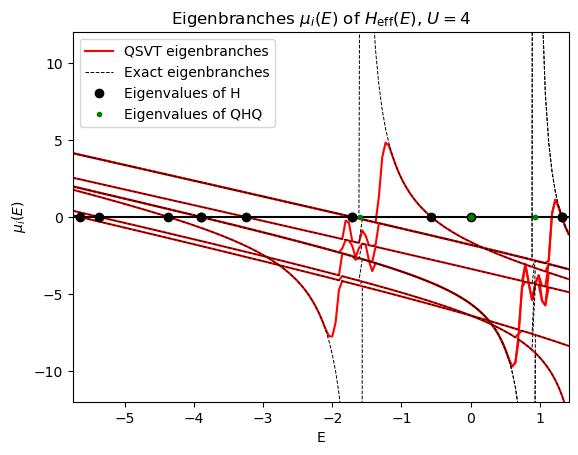

In [21]:
fig, ax = plt.subplots()

plt.xlabel('E')
plt.ylabel(r'$\mu_i(E)$')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(Xlim[0], -3)
# plt.xlim(4, 7)
plt.ylim(-12, 12)
plt.title(r'Eigenbranches $\mu_i(E)$ of $H_{\text{eff}}(E)$, $U=4$')

for i, Eigenbranch in enumerate(Eigenbranches):
    if i==0:
        ax.plot(Energy, Eigenbranch, 'red', label='QSVT eigenbranches')
    else:
        ax.plot(Energy, Eigenbranch, 'red')

for i, ED_Eigenbranch in enumerate(ED_Eigenbranches):
    if i==0:
        ax.plot(Energy, ED_Eigenbranch, 'black', linestyle='--', lw=0.7, label='Exact eigenbranches')
    else:
        ax.plot(Energy, ED_Eigenbranch, 'black', linestyle='--', lw=0.7)
ax.axhline(y=0, color='black')

ax.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black', label='Eigenvalues of H')
ax.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3, label='Eigenvalues of QHQ')

ax.legend(loc='upper left')
plt.show()

In [32]:
Eigenbranches[:, 0]

Array([0.10610636, 0.40312404, 1.77114075, 1.98220432, 1.98220432,
       2.5496868 , 4.14268289, 4.14268289], dtype=float64)

In [22]:
branches_fidelity_sweep = []
for i in range(degeneracy_dim):
    branches_fidelity_sweep.append([jnp.abs(jnp.real(ED_Eigenbranches_states[0, :, i]@ED_Eigenbranches_states[idx, :, i])) for idx in range(len(Energy))])

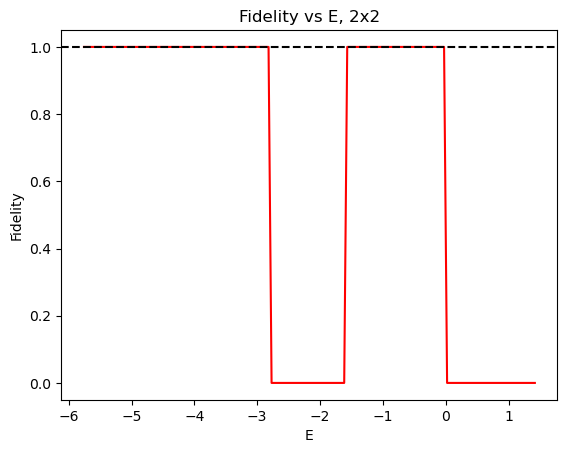

In [23]:
plt.plot(Energy, branches_fidelity_sweep[0], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

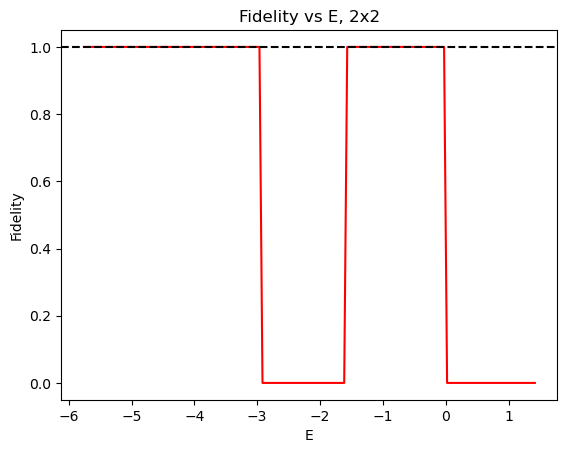

In [24]:
plt.plot(Energy, branches_fidelity_sweep[1], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

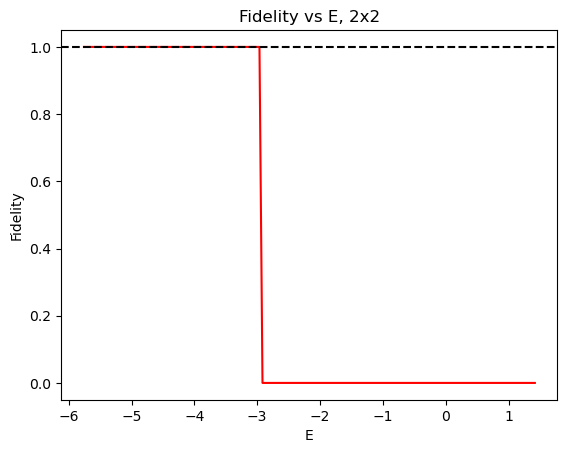

In [25]:
plt.plot(Energy, branches_fidelity_sweep[2], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

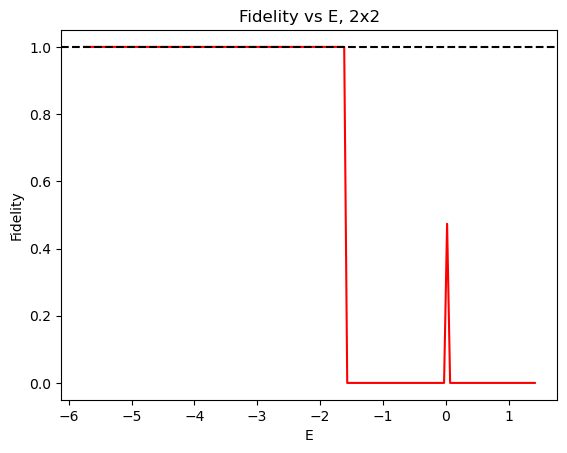

In [26]:
plt.plot(Energy, branches_fidelity_sweep[3], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

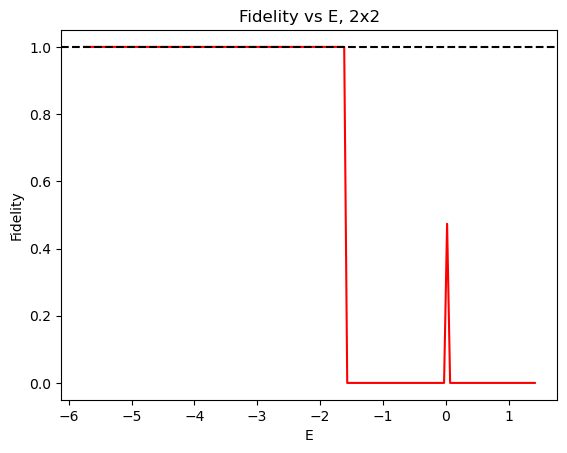

In [ ]:
plt.plot(Energy, branches_fidelity_sweep[4], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

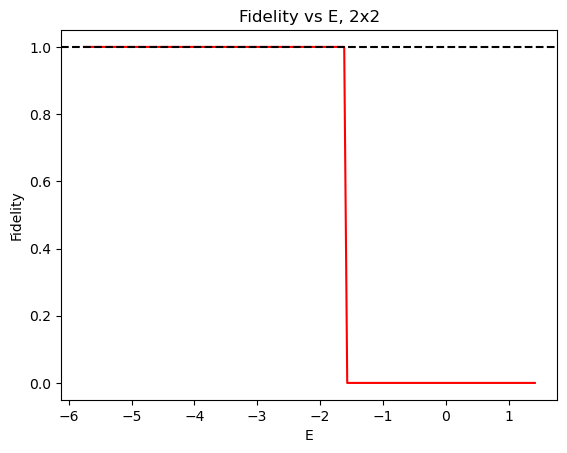

In [27]:
plt.plot(Energy, branches_fidelity_sweep[5], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

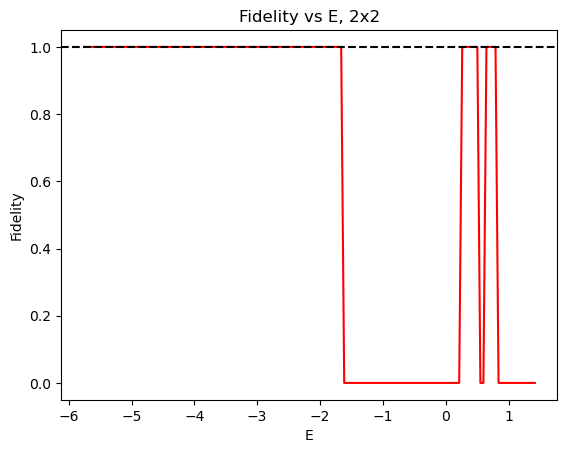

In [28]:
plt.plot(Energy, branches_fidelity_sweep[6], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

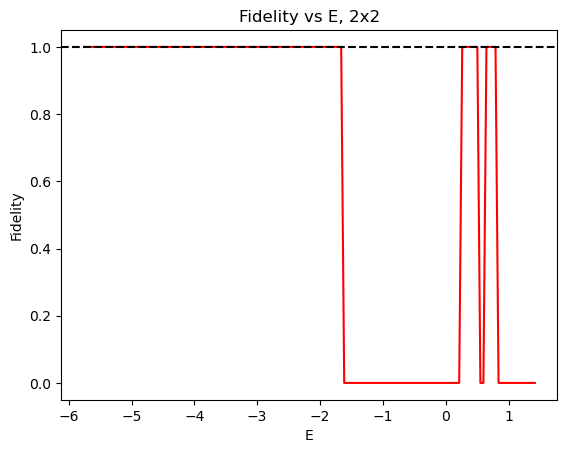

In [29]:
plt.plot(Energy, branches_fidelity_sweep[7], 'red')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('E')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()